# TCC - Modelo de Predição AVC
- Engenharia da Computação 10º Semestre e Ciência da Computação 8º Semestre- FAM Centro Universitário das Américas
- Alunos:
  - PEDRO HENRIQUE DE ALMEIDA SOUSA, 152918
  - DOUGLAS FÉLIX PHILIPINI SANTOS, 155608
  - NICOLAS RODRIGUES SILVA, 167315
  - IRIS CAPPARELLA WAGNER, 198165


## Importando bibliotecas e lendo a base do Kaggle

In [0]:
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import numpy as np
import random


In [0]:
arquivo = '/FileStore/tables/healthcare_dataset_stroke_data.csv'
file_type = 'csv'

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(arquivo)

display(df.limit(10))

id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
56669,Male,81,0,0,Yes,Private,Urban,186.21,29,formerly smoked,1
53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
10434,Female,69,0,0,No,Private,Urban,94.39,22.8,never smoked,1
27419,Female,59,0,0,Yes,Private,Rural,76.15,N/A,Unknown,1
60491,Female,78,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [0]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: string (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: string (nullable = true)



#### Renomeando colunas e alterando tipagem

In [0]:
df_spark_tratado = df.select(
    col('id').alias('ID').cast('integer'),
    col('gender').alias('GENERO'),
    col('age').alias('IDADE').cast('integer'),
    col('hypertension').alias('HIPERTENSO').cast('integer'),
    col('heart_disease').alias('DOENCA_CARDIACA').cast('integer'),
    col('ever_married').alias('JA_FOI_CASADO'),
    col('work_type').alias('PROFISSAO'),
    col('Residence_type').alias('RESIDENCIA'),
    col('avg_glucose_level').alias('NIVEL_MEDIO_GLICOSE').cast('double'),
    col('bmi').alias('IMC').cast('double'),
    col('smoking_status').alias('FUMA'),
    col('stroke').alias('AVC').cast('integer')
)

In [0]:
display(df_spark_tratado.limit(10))

ID,GENERO,IDADE,HIPERTENSO,DOENCA_CARDIACA,JA_FOI_CASADO,PROFISSAO,RESIDENCIA,NIVEL_MEDIO_GLICOSE,IMC,FUMA,AVC
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,null,never smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
53882,Male,74,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
10434,Female,69,0,0,No,Private,Urban,94.39,22.8,never smoked,1
27419,Female,59,0,0,Yes,Private,Rural,76.15,null,Unknown,1
60491,Female,78,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [0]:
df_spark_tratado.select('IDADE').distinct().orderBy('IDADE', ascending = True).show()

+-----+
|IDADE|
+-----+
|    0|
|    1|
|    2|
|    3|
|    4|
|    5|
|    6|
|    7|
|    8|
|    9|
|   10|
|   11|
|   12|
|   13|
|   14|
|   15|
|   16|
|   17|
|   18|
|   19|
+-----+
only showing top 20 rows



In [0]:
df_spark_tratado.filter((col('IDADE') <= 40) & (col('AVC') == 1)).orderBy('IDADE', ascending = True).show()

+-----+------+-----+----------+---------------+-------------+-------------+----------+-------------------+----+---------------+---+
|   ID|GENERO|IDADE|HIPERTENSO|DOENCA_CARDIACA|JA_FOI_CASADO|    PROFISSAO|RESIDENCIA|NIVEL_MEDIO_GLICOSE| IMC|           FUMA|AVC|
+-----+------+-----+----------+---------------+-------------+-------------+----------+-------------------+----+---------------+---+
|69768|Female|    1|         0|              0|           No|     children|     Urban|              70.37|null|        Unknown|  1|
|49669|Female|   14|         0|              0|           No|     children|     Rural|              57.93|30.9|        Unknown|  1|
|39912|Female|   32|         0|              0|          Yes|      Private|     Rural|              76.13|29.9|         smokes|  1|
|31720|Female|   38|         0|              0|           No|Self-employed|     Urban|              82.28|24.0|formerly smoked|  1|
|31563|Female|   38|         0|              0|          Yes|      Private| 

## Análise Exploratória

In [0]:
#Quantidade de pessoas que sofreram AVC

df_spark_tratado.groupBy('AVC').count().show()



+-----+-----+
|  AVC|count|
+-----+-----+
| true|  249|
|false| 4861|
+-----+-----+



In [0]:
df_spark_tratado.groupBy('FUMA').count().show()

+---------------+-----+
|           FUMA|count|
+---------------+-----+
|         smokes|  789|
|        Unknown| 1544|
|   never smoked| 1892|
|formerly smoked|  885|
+---------------+-----+



In [0]:
df_spark_tratado.groupBy('RESIDENCIA').count().show()

+----------+-----+
|RESIDENCIA|count|
+----------+-----+
|     Urban| 2596|
|     Rural| 2514|
+----------+-----+



In [0]:
df_spark_tratado.groupBy('PROFISSAO').count().show()

+-------------+-----+
|    PROFISSAO|count|
+-------------+-----+
| Never_worked|   22|
|Self-employed|  819|
|      Private| 2925|
|     children|  687|
|     Govt_job|  657|
+-------------+-----+



In [0]:
df_spark_tratado.groupBy('JA_FOI_CASADO').count().show()

+-------------+-----+
|JA_FOI_CASADO|count|
+-------------+-----+
|         true| 3353|
|        false| 1757|
+-------------+-----+



In [0]:
df_spark_tratado.groupBy('GENERO').count().show()

+------+-----+
|GENERO|count|
+------+-----+
|Female| 2994|
| Other|    1|
|  Male| 2115|
+------+-----+



In [0]:
df_spark_tratado.groupBy('HIPERTENSO').count().show()

+----------+-----+
|HIPERTENSO|count|
+----------+-----+
|         1|  498|
|         0| 4612|
+----------+-----+



In [0]:
df_spark_tratado.summary().show()

+-------+-----------------+------+------------------+------------------+-------------------+-------------+---------+----------+-------------------+------------------+-------+-------------------+
|summary|               ID|GENERO|             IDADE|        HIPERTENSO|    DOENCA_CARDIACA|JA_FOI_CASADO|PROFISSAO|RESIDENCIA|NIVEL_MEDIO_GLICOSE|               IMC|   FUMA|                AVC|
+-------+-----------------+------+------------------+------------------+-------------------+-------------+---------+----------+-------------------+------------------+-------+-------------------+
|  count|             5110|  5110|              5110|              5110|               5110|         5110|     5110|      5110|               5110|              4909|   5110|               5110|
|   mean|36517.82935420744|  null| 43.21526418786693|0.0974559686888454|0.05401174168297456|         null|     null|      null| 106.14767710371804|28.893236911794673|   null| 0.0487279843444227|
| stddev|21161.7216248271

In [0]:
#Transformei em Pandas para facilitar as análises com gráfico
df_pd = df_spark_tratado.toPandas()

In [0]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   5110 non-null   int32  
 1   GENERO               5110 non-null   object 
 2   IDADE                5110 non-null   int32  
 3   HIPERTENSO           5110 non-null   int32  
 4   DOENCA_CARDIACA      5110 non-null   int32  
 5   JA_FOI_CASADO        5110 non-null   object 
 6   PROFISSAO            5110 non-null   object 
 7   RESIDENCIA           5110 non-null   object 
 8   NIVEL_MEDIO_GLICOSE  5110 non-null   float64
 9   IMC                  4909 non-null   float64
 10  FUMA                 5110 non-null   object 
 11  AVC                  5110 non-null   int32  
dtypes: float64(2), int32(5), object(5)
memory usage: 379.4+ KB


In [0]:
    df_pd\
    .describe(percentiles = [0.25, 0.5, 0.75, 0.8, 0.9])\
    .T\
    .drop(columns=['count'])\
    .style\
    .background_gradient(axis=1)
    .savefig('summary.png', format='png')


,mean,std,min,25%,50%,75%,80%,90%,max
ID,36517.829354,21161.721625,67.000000,17741.250000,36932.000000,54682.000000,58153.200000,65667.600000,72940.000000
IDADE,43.215264,22.633866,0.000000,25.000000,45.000000,61.000000,65.000000,75.000000,82.000000
HIPERTENSO,0.097456,0.296607,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
DOENCA_CARDIACA,0.054012,0.226063,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
NIVEL_MEDIO_GLICOSE,106.147677,45.283560,55.120000,77.245000,91.885000,114.090000,124.160000,192.181000,271.740000
IMC,28.893237,7.854067,10.300000,23.500000,28.100000,33.100000,34.500000,38.900000,97.600000
AVC,0.048728,0.215320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


Out[22]: <AxesSubplot:xlabel='AVC', ylabel='NIVEL_MEDIO_GLICOSE'>

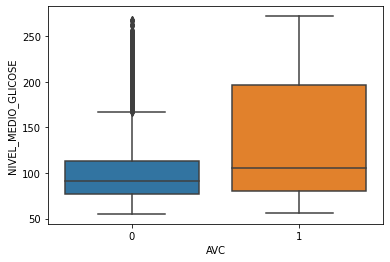

In [0]:
sns.boxplot(data = df_pd, x="AVC", y="NIVEL_MEDIO_GLICOSE")

Out[23]: <AxesSubplot:xlabel='AVC', ylabel='IMC'>

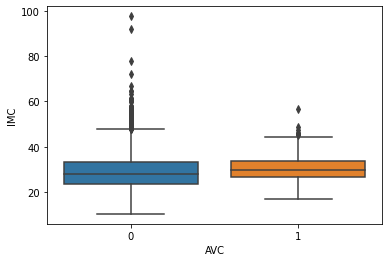

In [0]:
sns.boxplot(data = df_pd, x="AVC", y="IMC")

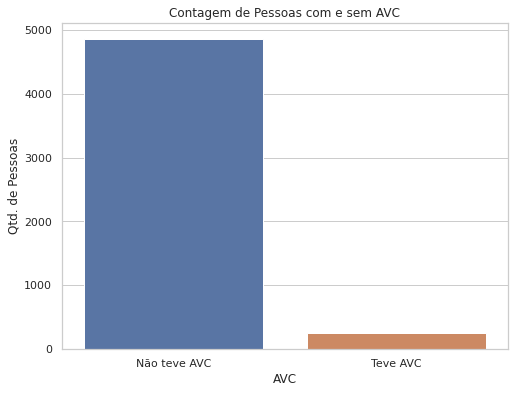

Não tiveram AVC:  4861
Tiveram AVC:  249


In [0]:
df_nao_teve_avc = df_pd[df_pd['AVC'] == 0]
df_teve_avc = df_pd[df_pd['AVC'] == 1]

eixo_Y = [len(df_nao_teve_avc), len(df_teve_avc)]
eixo_X = ['Não teve AVC', 'Teve AVC']

# Criar o gráfico de barras com Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.barplot(x=eixo_X, y=eixo_Y)

plt.xlabel('AVC')
plt.ylabel('Qtd. de Pessoas')
plt.title('Contagem de Pessoas com e sem AVC')

# Exibir o gráfico
plt.show()

print('Não tiveram AVC: ',len(df_nao_teve_avc))
print('Tiveram AVC: ', len(df_teve_avc))

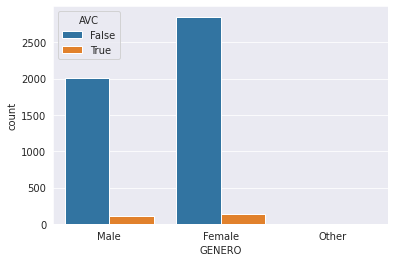

In [0]:
sns.set_style('darkgrid')
sns.countplot(data=df_pd, x='GENERO', hue='AVC')
plt.show()

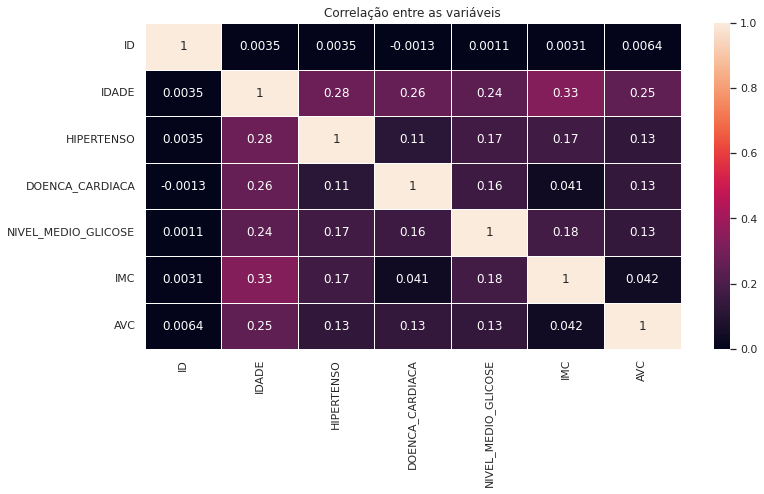

In [0]:
plt.figure(figsize=(12, 6))
 
plt.title('Correlação entre as variáveis')
 
sns.heatmap(
    df_pd.corr(), annot=True, linewidths=1
)
 
plt.show()

## Tratamento dos dados

#### Nulos e Faltantes

In [0]:
percentual_nulos = (df_pd.isna().sum() / len(df_pd)) * 100
display(percentual_nulos)

print('\n Quantidade de nulos da variável IMC: ',df_pd['IMC'].isna().sum())

ID                     0.000000
GENERO                 0.000000
IDADE                  0.000000
HIPERTENSO             0.000000
DOENCA_CARDIACA        0.000000
JA_FOI_CASADO          0.000000
PROFISSAO              0.000000
RESIDENCIA             0.000000
NIVEL_MEDIO_GLICOSE    0.000000
IMC                    3.933464
FUMA                   0.000000
AVC                    0.000000
dtype: float64
 Quantidade de nulos da variável IMC:  201


In [0]:
# Substituindo os valores nulos pela mediana

mediana_imc = df_pd['IMC'].median()
df_pd['IMC'].fillna(mediana_imc, inplace=True)

percentual_nulos = (df_pd.isna().sum() / len(df_pd)) * 100
display(percentual_nulos)

ID                     0.0
GENERO                 0.0
IDADE                  0.0
HIPERTENSO             0.0
DOENCA_CARDIACA        0.0
JA_FOI_CASADO          0.0
PROFISSAO              0.0
RESIDENCIA             0.0
NIVEL_MEDIO_GLICOSE    0.0
IMC                    0.0
FUMA                   0.0
AVC                    0.0
dtype: float64

In [0]:
label_encoder = LabelEncoder()

df_pd['HIPERTENSO'] = label_encoder.fit_transform(df_pd['HIPERTENSO'])
df_pd['DOENCA_CARDIACA'] = label_encoder.fit_transform(df_pd['DOENCA_CARDIACA'])
df_pd['JA_FOI_CASADO'] = label_encoder.fit_transform(df_pd['JA_FOI_CASADO'])
df_pd['RESIDENCIA'] = label_encoder.fit_transform(df_pd['RESIDENCIA'])

In [0]:
df_pd.head()

,ID,GENERO,IDADE,HIPERTENSO,DOENCA_CARDIACA,JA_FOI_CASADO,PROFISSAO,RESIDENCIA,NIVEL_MEDIO_GLICOSE,IMC,FUMA,AVC
0,9046,Male,67,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,1,Self-employed,0,202.21,28.1,never smoked,1
2,31112,Male,80,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79,1,0,1,Self-employed,0,174.12,24.0,never smoked,1


In [0]:
df_pd = pd.get_dummies(df_pd, columns=['GENERO', 'PROFISSAO', 'FUMA'], prefix='', prefix_sep='')

In [0]:
df_pd.head()

,ID,IDADE,HIPERTENSO,DOENCA_CARDIACA,JA_FOI_CASADO,RESIDENCIA,NIVEL_MEDIO_GLICOSE,IMC,AVC,Female,...,Other,Govt_job,Never_worked,Private,Self-employed,children,Unknown,formerly smoked,never smoked,smokes
0,9046,67,0,1,1,1,228.69,36.6,1,0,...,0,0,0,1,0,0,0,1,0,0
1,51676,61,0,0,1,0,202.21,28.1,1,1,...,0,0,0,0,1,0,0,0,1,0
2,31112,80,0,1,1,0,105.92,32.5,1,0,...,0,0,0,1,0,0,0,0,1,0
3,60182,49,0,0,1,1,171.23,34.4,1,1,...,0,0,0,1,0,0,0,0,0,1
4,1665,79,1,0,1,0,174.12,24.0,1,1,...,0,0,0,0,1,0,0,0,1,0


In [0]:
df_pd['MASCULINO'] = df_pd['Male']
df_pd['FEMININO'] = df_pd['Female']
df_pd['OUTROS'] = df_pd['Other']
df_pd['TP_TRAB_FUNCIONARIO_PUBLICO'] = df_pd['Govt_job']
df_pd['TP_TRAB_NUNCA_TRABALHOU'] = df_pd['Never_worked']
df_pd['TP_TRAB_PRIVADO'] = df_pd['Private']
df_pd['TP_TRAB_AUTONOMO'] = df_pd['Self-employed']
df_pd['TP_TRAB_CRIANCA'] = df_pd['children']
df_pd['TP_TRAB_DESCONHECIDO'] = df_pd['Unknown']
df_pd['EX_FUMANTE'] = df_pd['formerly smoked']
df_pd['NUNCA_FUMOU'] = df_pd['never smoked']
df_pd['FUMANTE'] = df_pd['smokes']


df_pd.drop(columns=['Male', 'Female', 'Other', 'Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children', 'Unknown', 'formerly smoked', 'never smoked', 'smokes' ], inplace=True)

In [0]:
df_pd.head()

,ID,IDADE,HIPERTENSO,DOENCA_CARDIACA,JA_FOI_CASADO,RESIDENCIA,NIVEL_MEDIO_GLICOSE,IMC,AVC,MASCULINO,...,OUTROS,TP_TRAB_FUNCIONARIO_PUBLICO,TP_TRAB_NUNCA_TRABALHOU,TP_TRAB_PRIVADO,TP_TRAB_AUTONOMO,TP_TRAB_CRIANCA,TP_TRAB_DESCONHECIDO,EX_FUMANTE,NUNCA_FUMOU,FUMANTE
0,9046,67,0,1,1,1,228.69,36.6,1,1,...,0,0,0,1,0,0,0,1,0,0
1,51676,61,0,0,1,0,202.21,28.1,1,0,...,0,0,0,0,1,0,0,0,1,0
2,31112,80,0,1,1,0,105.92,32.5,1,1,...,0,0,0,1,0,0,0,0,1,0
3,60182,49,0,0,1,1,171.23,34.4,1,0,...,0,0,0,1,0,0,0,0,0,1
4,1665,79,1,0,1,0,174.12,24.0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [0]:
df_pd.drop(columns=['ID'], inplace=True)

In [0]:
df_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IDADE                        5110 non-null   int32  
 1   HIPERTENSO                   5110 non-null   int64  
 2   DOENCA_CARDIACA              5110 non-null   int64  
 3   JA_FOI_CASADO                5110 non-null   int64  
 4   RESIDENCIA                   5110 non-null   int64  
 5   NIVEL_MEDIO_GLICOSE          5110 non-null   float64
 6   IMC                          5110 non-null   float64
 7   AVC                          5110 non-null   int32  
 8   MASCULINO                    5110 non-null   uint8  
 9   FEMININO                     5110 non-null   uint8  
 10  OUTROS                       5110 non-null   uint8  
 11  TP_TRAB_FUNCIONARIO_PUBLICO  5110 non-null   uint8  
 12  TP_TRAB_NUNCA_TRABALHOU      5110 non-null   uint8  
 13  TP_TRAB_PRIVADO   

## Balanceamento dos dados

In [0]:

df_teve_avc = df_pd[df_pd['AVC'] == 1]
df_nao_teve_avc =  df_pd[df_pd['AVC'] == 0]

balanceamento = pd.concat([
    df_teve_avc,
    df_nao_teve_avc
    .sample(n=len(df_teve_avc))],axis=0

)

Out[52]: <AxesSubplot:>

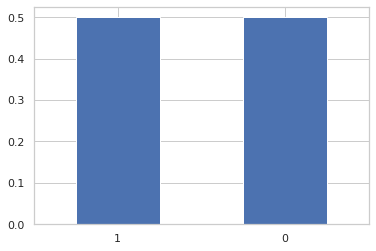

In [0]:
balanceamento['AVC'].value_counts(normalize = True).plot(kind='bar', rot = 0)

## Treino e Teste

In [0]:
display(balanceamento)

/databricks/spark/python/pyspark/sql/pandas/conversion.py:467: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field MASCULINO. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion from Arrow: uint8
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


IDADE,HIPERTENSO,DOENCA_CARDIACA,JA_FOI_CASADO,RESIDENCIA,NIVEL_MEDIO_GLICOSE,IMC,AVC,MASCULINO,FEMININO,OUTROS,TP_TRAB_FUNCIONARIO_PUBLICO,TP_TRAB_NUNCA_TRABALHOU,TP_TRAB_PRIVADO,TP_TRAB_AUTONOMO,TP_TRAB_CRIANCA,TP_TRAB_DESCONHECIDO,EX_FUMANTE,NUNCA_FUMOU,FUMANTE
67,0,1,1,1,228.69,36.6,1,1,0,0,0,0,1,0,0,0,1,0,0
61,0,0,1,0,202.21,28.1,1,0,1,0,0,0,0,1,0,0,0,1,0
80,0,1,1,0,105.92,32.5,1,1,0,0,0,0,1,0,0,0,0,1,0
49,0,0,1,1,171.23,34.4,1,0,1,0,0,0,1,0,0,0,0,0,1
79,1,0,1,0,174.12,24.0,1,0,1,0,0,0,0,1,0,0,0,1,0
81,0,0,1,1,186.21,29.0,1,1,0,0,0,0,1,0,0,0,1,0,0
74,1,1,1,0,70.09,27.4,1,1,0,0,0,0,1,0,0,0,0,1,0
69,0,0,0,1,94.39,22.8,1,0,1,0,0,0,1,0,0,0,0,1,0
59,0,0,1,0,76.15,28.1,1,0,1,0,0,0,1,0,0,1,0,0,0
78,0,0,1,1,58.57,24.2,1,0,1,0,0,0,1,0,0,1,0,0,0


In [0]:
columns = df_pd.columns.tolist()

len(columns)

Out[29]: 20

In [0]:
Y = balanceamento['AVC'].values
X = balanceamento[['IDADE', 'HIPERTENSO', 'DOENCA_CARDIACA', 'JA_FOI_CASADO', 'RESIDENCIA', 'NIVEL_MEDIO_GLICOSE', 'IMC', 'MASCULINO', 'FEMININO', 'OUTROS', 'TP_TRAB_FUNCIONARIO_PUBLICO', 'TP_TRAB_NUNCA_TRABALHOU', 'TP_TRAB_PRIVADO', 'TP_TRAB_AUTONOMO', 'TP_TRAB_CRIANCA', 'TP_TRAB_DESCONHECIDO', 'EX_FUMANTE', 'NUNCA_FUMOU', 'FUMANTE']].values

In [0]:
np.random.seed(1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [0]:
modelo = RandomForestClassifier(n_estimators =100, n_jobs = -1, random_state = 0)

In [0]:
modelo.fit(X_train, Y_train)

Out[43]: RandomForestClassifier(n_jobs=-1, random_state=0)

In [0]:
Y_predict = modelo.predict(X_test)

In [0]:
print(f'recall: {recall_score(Y_test, Y_predict)}')
print(f'precision: {precision_score(Y_test, Y_predict)}')
print(f'accuracy: {accuracy_score(Y_test, Y_predict)}')
print(f'f1_score: {f1_score(Y_test, Y_predict)}')

recall: 0.8088235294117647
precision: 0.6790123456790124
accuracy: 0.74
f1_score: 0.7382550335570469


Matriz de Confusão:
[[56 26]
 [13 55]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.81      0.68      0.74        82
           1       0.68      0.81      0.74        68

    accuracy                           0.74       150
   macro avg       0.75      0.75      0.74       150
weighted avg       0.75      0.74      0.74       150

AUC: 0.8387733142037304


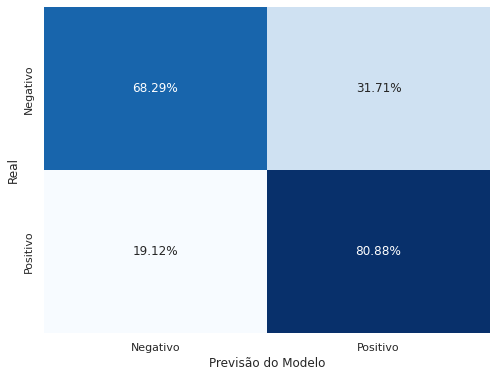

In [0]:
# Gerar a matriz de confusão
conf_matrix = confusion_matrix(Y_test, Y_predict)
print("Matriz de Confusão:")
print(conf_matrix)

# Gerar um relatório de classificação (que inclui precision, recall e f1-score)
class_report = classification_report(Y_test, Y_predict)
print("Relatório de Classificação:")
print(class_report)

# Calcular a AUC (área sob a curva ROC)
y_prob = modelo.predict_proba(X_test)[:, 1]
auc = roc_auc_score(Y_test, y_prob)
print("AUC:", auc)

conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plotar a matriz de confusão em percentagens
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2%", cmap="Blues", cbar=False, xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Previsão do Modelo")
plt.ylabel("Real")

plt.show()

Feature ranking:
1. feature 0 (0.354573)
2. feature 5 (0.171133)
3. feature 6 (0.168458)
4. feature 3 (0.041009)
5. feature 2 (0.029880)
6. feature 4 (0.025437)
7. feature 16 (0.024844)
8. feature 1 (0.024720)
9. feature 17 (0.023533)
10. feature 15 (0.021063)
11. feature 7 (0.019203)
12. feature 13 (0.018576)
13. feature 12 (0.017970)
14. feature 8 (0.017037)
15. feature 18 (0.016582)
16. feature 10 (0.014509)
17. feature 14 (0.011472)
18. feature 11 (0.000000)
19. feature 9 (0.000000)


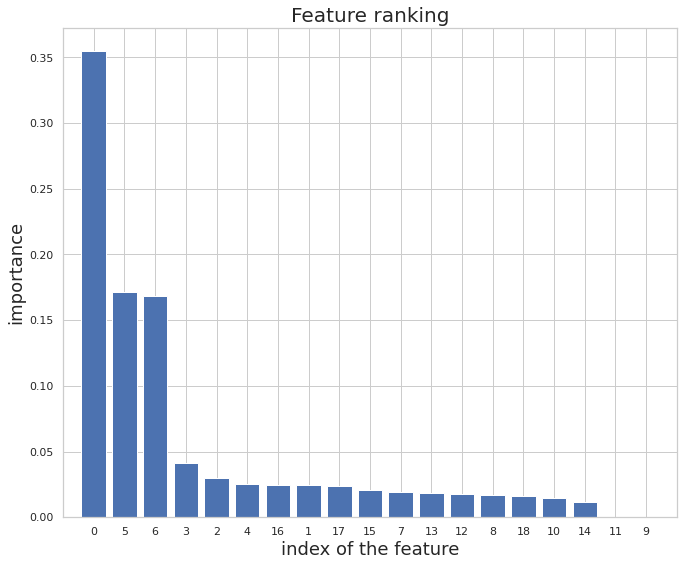

Out[55]: Index(['IDADE', 'HIPERTENSO', 'DOENCA_CARDIACA', 'JA_FOI_CASADO', 'RESIDENCIA',
       'NIVEL_MEDIO_GLICOSE', 'IMC', 'MASCULINO', 'FEMININO', 'OUTROS',
       'TP_TRAB_FUNCIONARIO_PUBLICO', 'TP_TRAB_NUNCA_TRABALHOU',
       'TP_TRAB_PRIVADO', 'TP_TRAB_AUTONOMO', 'TP_TRAB_CRIANCA',
       'TP_TRAB_DESCONHECIDO', 'EX_FUMANTE', 'NUNCA_FUMOU', 'FUMANTE'],
      dtype='object')

In [0]:
importances = modelo.feature_importances_

indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()


df_pd.drop(columns=['AVC']).columns[:]